In [ ]:
SEED = 365

In [ ]:
import sys

from timm import create_model
from timm.data.mixup import Mixup

from fastai.vision.all import *

In [3]:
set_seed(SEED, reproducible=True)
BATCH_SIZE = 8
NEED_TRAIN = True

In [4]:
train_df = pd.read_csv(r'F:\Pycharm_projects\PetFinder\data\train_10folds_rice_fold.csv')
dataset_path = Path('../input/petfinder-pawpularity-score/train/')
train_df['path'] = train_df['Id'].map(lambda x: str(dataset_path/x) + '.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,Breed,kfold,path
0,0,1,1,1,0,0,0,0,0,0,0,0,25,1,8,../input/petfinder-pawpularity-score/train/7b4c408fa4ad8bc1d1a720dc0417c8b6.jpg
1,0,1,1,1,0,0,0,0,0,0,0,0,36,0,2,../input/petfinder-pawpularity-score/train/b9cf47f8b3b5a0855bb3293b138776e5.jpg
2,0,1,1,0,0,0,0,0,1,1,0,0,51,1,8,../input/petfinder-pawpularity-score/train/ff903858a9899465ee4cd17e942bef24.jpg
3,1,1,1,1,0,0,0,0,0,0,0,0,29,1,5,../input/petfinder-pawpularity-score/train/86ccbbb4eee306d37ac4c41c031ffce5.jpg
4,0,1,1,1,0,0,0,0,0,0,0,0,17,0,0,../input/petfinder-pawpularity-score/train/fe80fffa8bab0dafba63a9b4f07b557a.jpg


In [5]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

0       0.25
1       0.36
2       0.51
3       0.29
4       0.17
        ... 
9880    0.54
9881    0.27
9882    0.42
9883    0.76
9884    0.30
Name: norm_score, Length: 9885, dtype: float64

In [6]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [7]:
seed=SEED
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [8]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [9]:
train_df['norm_score'] = train_df['Pawpularity']/100

import gc

from sklearn.metrics import mean_squared_error
folds = [0,1,2,3,4,5,6,7,8,9]
if NEED_TRAIN:
    rmse_list = []
    #train_df['oof'] = -1

    for i in folds:

        print(f'Fold {i} results')

        # ----------------
        # Change Path here
        # ----------------
        learn  = load_learner(fname=Path(f'../input/fastai-384-pred/swin_large_patch4_window12_384/model_fold_{i}.pkl'), cpu=False)
        
        val_idx = train_df[train_df['kfold'] == i].index
        val_df = train_df.loc[val_idx]
        
        test_dl = learn.dls.test_dl(val_df)
        
        val_pred, _ =learn.tta(dl=test_dl,n=5, beta=0.2)
        val_pred = val_pred.numpy()
        val_pred = val_pred * 100
        
        train_df.loc[val_idx, 'oof'] = val_pred
        print('Pawpularity vs OOF')
        print(val_df['Pawpularity'][:5], val_pred[:5])
        
        real_rmse = mean_squared_error(train_df[train_df['kfold'] == i]['Pawpularity'], 
                    train_df[train_df['kfold'] == i]['oof'], squared=False)
        
        fold_rmse = mean_squared_error(train_df[train_df['kfold'] == i]['oof'], train_df[train_df['kfold'] == i]['Pawpularity'], squared=False)
        print(f'Fold {i} RMSE: {fold_rmse}')
        rmse_list.append(fold_rmse)

        del learn

        torch.cuda.empty_cache()

        gc.collect()

print(f'Average Fold RMSE: {sum(rmse_list) / len(rmse_list)}')

Fold 0 results


Pawpularity vs OOF
4     17
6     20
10    28
19    43
21    32
Name: Pawpularity, dtype: int64 [[26.06312 ]
 [32.279415]
 [38.362972]
 [39.084564]
 [54.79288 ]]
Fold 0 RMSE: 16.94825465562056
Fold 1 results


Pawpularity vs OOF
7     63
11    67
18    39
20    36
31    29
Name: Pawpularity, dtype: int64 [[47.093147]
 [47.5447  ]
 [34.2781  ]
 [27.27301 ]
 [50.16638 ]]
Fold 1 RMSE: 17.93535502890475
Fold 2 results


Pawpularity vs OOF
1     36
68    30
69    20
70    24
80    25
Name: Pawpularity, dtype: int64 [[32.947937]
 [32.818394]
 [28.15123 ]
 [29.985958]
 [24.700356]]
Fold 2 RMSE: 17.240240151787933
Fold 3 results


Pawpularity vs OOF
13    33
23    63
46    40
49     2
51    55
Name: Pawpularity, dtype: int64 [[29.895258]
 [43.764942]
 [27.198523]
 [32.153805]
 [43.637447]]
Fold 3 RMSE: 18.200891953374644
Fold 4 results


Pawpularity vs OOF
15    23
26    41
38    26
58    27
73    44
Name: Pawpularity, dtype: int64 [[37.9936  ]
 [30.75538 ]
 [43.413082]
 [39.36731 ]
 [50.377457]]
Fold 4 RMSE: 17.501156033200978
Fold 5 results


Pawpularity vs OOF
3     29
12    15
29    30
40    19
50    34
Name: Pawpularity, dtype: int64 [[36.79422 ]
 [33.20274 ]
 [32.23276 ]
 [32.15597 ]
 [30.810474]]
Fold 5 RMSE: 16.571443920356398
Fold 6 results


Pawpularity vs OOF
17    19
33    53
34    10
41    27
42    21
Name: Pawpularity, dtype: int64 [[30.793901]
 [49.05672 ]
 [25.438309]
 [37.826042]
 [31.57037 ]]
Fold 6 RMSE: 17.178142338534208
Fold 7 results


Pawpularity vs OOF
14    34
24    50
39    22
48    61
64     2
Name: Pawpularity, dtype: int64 [[34.36949 ]
 [29.306408]
 [30.825684]
 [46.04372 ]
 [34.937756]]
Fold 7 RMSE: 17.30195262772249
Fold 8 results


Pawpularity vs OOF
0     25
2     51
5     45
27    38
43    38
Name: Pawpularity, dtype: int64 [[32.770164]
 [37.63737 ]
 [42.266987]
 [47.650608]
 [32.279747]]
Fold 8 RMSE: 17.55951062752766
Fold 9 results


Pawpularity vs OOF
8     68
9     38
16    19
28    41
30    47
Name: Pawpularity, dtype: int64 [[35.410103]
 [37.371086]
 [36.864834]
 [37.89806 ]
 [31.559298]]
Fold 9 RMSE: 18.045518749048952
Average Fold RMSE: 17.44824660860786


<AxesSubplot:xlabel='oof', ylabel='Pawpularity'>

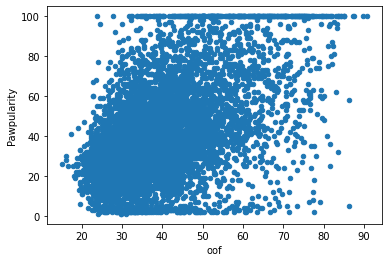

In [10]:
train_df[['oof','Pawpularity']].plot.scatter('oof','Pawpularity')

array([[<AxesSubplot:title={'center':'oof'}>,
        <AxesSubplot:title={'center':'Pawpularity'}>]], dtype=object)

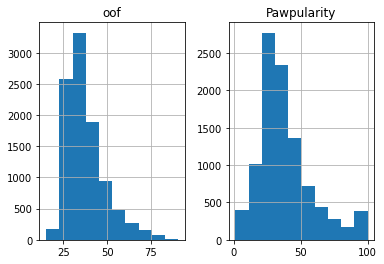

In [11]:
train_df[['oof','Pawpularity']].hist()

In [12]:
train_df.to_csv('train_with_oof.csv')